## Desafio Fraude em Crédito

[Dataset Fraudes Transações Setembro 2013 Europa](https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv)

O seu desafio é clusterizar as transações isolando possiveis fraudes.

In [18]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
#Pre processamento
## Escalonamento de features
from sklearn.preprocessing import StandardScaler
##Selecionar as melhores features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [20]:
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
df = pd.read_csv('/content/drive/MyDrive/Awari/Desafio - Fraudes de Crédito /creditcard.csv')

In [23]:
df.shape

(284807, 31)

In [24]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [25]:
df.info()
# Class 0: Não é fraude
# Class 1: É fraude

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [26]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [27]:
df.isna().sum().sum()

0

In [28]:
df.duplicated().value_counts()
# Analisar se pode ou não ocorrer duplicados ou não.

False    283726
True       1081
dtype: int64

In [29]:
# Retirar a variável Class para analisar as demais
# Todas as demais variáveis são variáveis contínuas
df_features = df.drop(columns='Class')
df_target = pd.DataFrame(df['Class'])

In [30]:
print(df_target.shape)
print(df_features.shape)

(284807, 1)
(284807, 30)


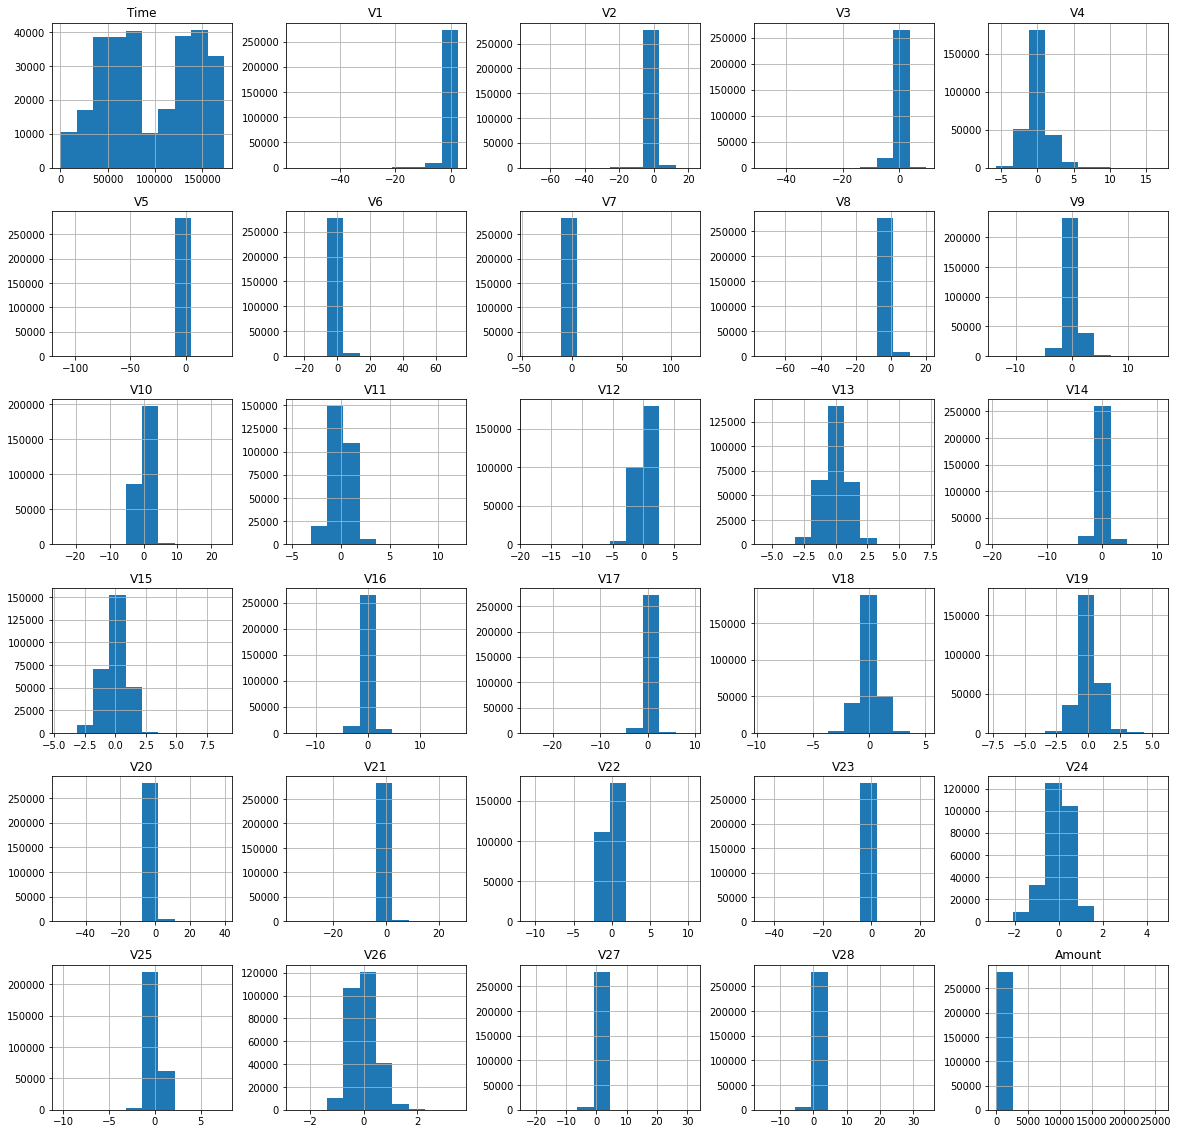

In [31]:
df_features.hist(figsize=(20,20), bins=10)
plt.show()

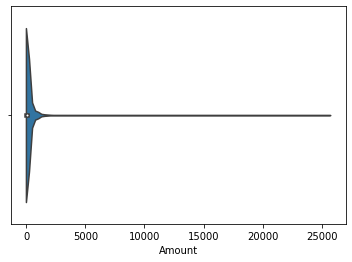

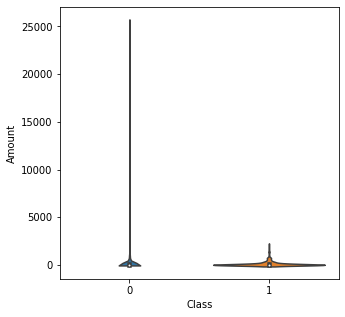

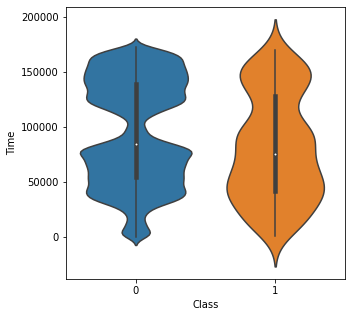

In [32]:
# A distribuição do Amount e Time chamaram atenção
sns.violinplot(data=df_features, x='Amount')
plt.show()

plt.figure(figsize=(5,5))
sns.violinplot(x='Class', y = 'Amount' , data=df)
plt.show()

plt.figure(figsize=(5,5))
sns.violinplot(x='Class', y = 'Time' , data=df)
plt.show()

In [33]:
# Para o Time e Amount, foi decidido realizar um Standard Z-Scale
z_score = StandardScaler()
def std_z_scale(df,col):
  df[col] = z_score.fit_transform(df[[col]])

In [34]:
# Testando o impacto do Std Z-Scale em todas as features
'''
X = df_features.copy()
for col in X.columns:
  std_z_scale(X,col)

X.hist(figsize=(20,20), bins=10)
plt.show()
'''
# Conclusão: não necessitam de escalonamento.

'\nX = df_features.copy()\nfor col in X.columns:\n  std_z_scale(X,col)\n\nX.hist(figsize=(20,20), bins=10)\nplt.show()\n'

In [35]:
# Aplicando Standard Z-Scale nas features
std_z_scale(df_features,'Amount')
std_z_scale(df_features,'Time')

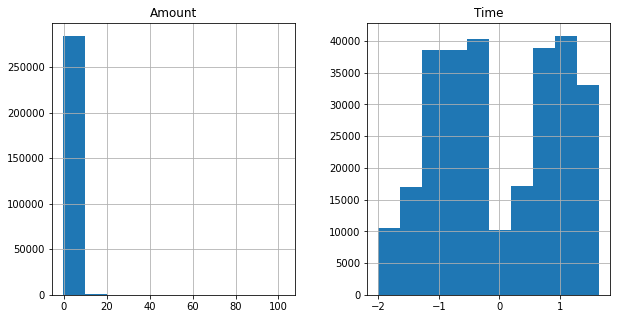

In [36]:
df_features[['Amount', 'Time']].hist(figsize=(10,5), bins=10)
plt.show()

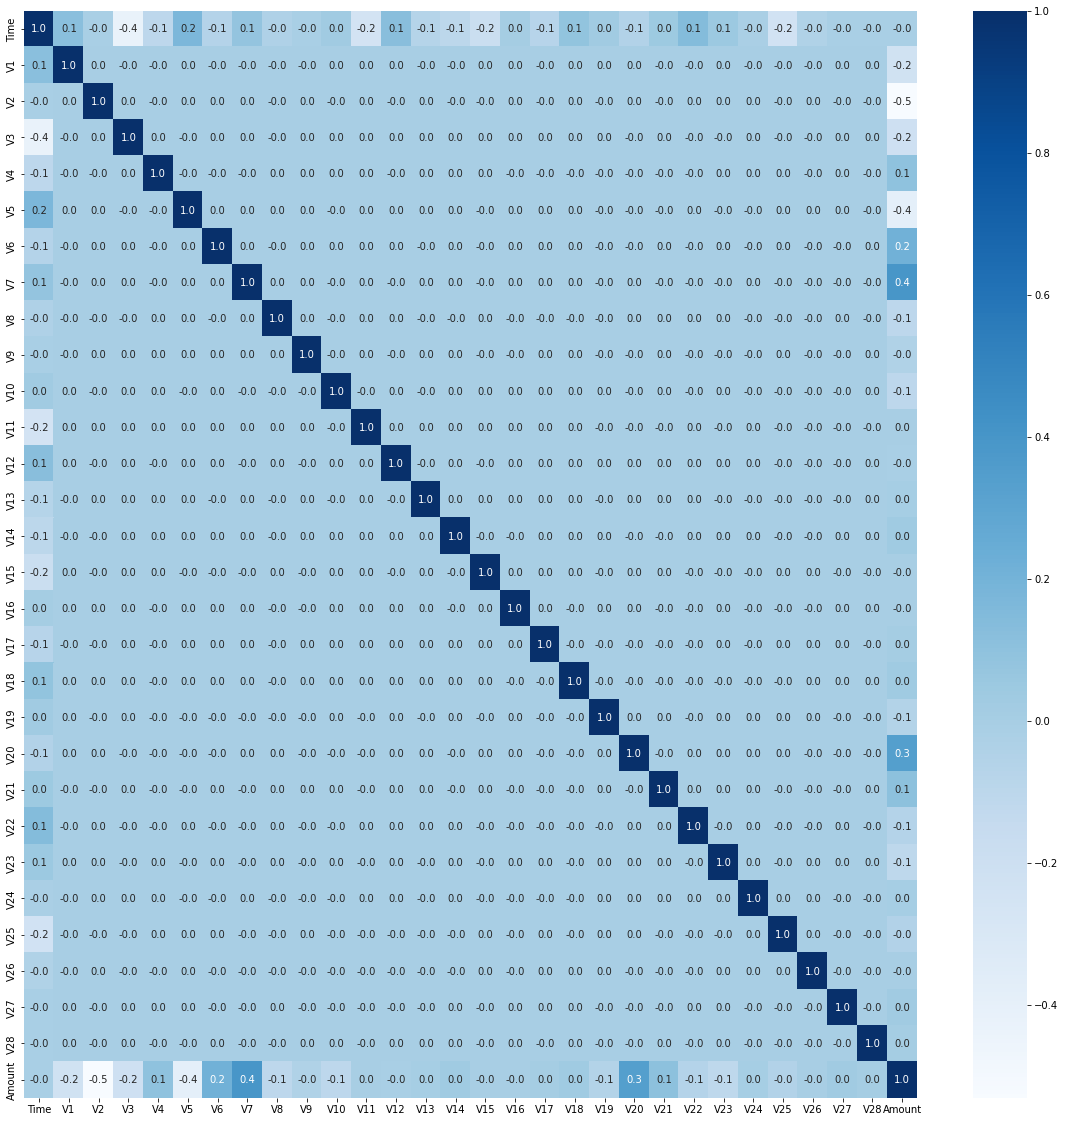

In [37]:
plt.figure(figsize=(20,20))
sns.heatmap(df_features.corr(),annot=True,fmt='.1f',cmap='Blues')
plt.show()

In [38]:
# Analise de quantidade de fraudes
df_target.value_counts()

Class
0        284315
1           492
dtype: int64

## Selecionando as melhores features

1º passo: Saber quantas features você irá selecionar

In [39]:
# Selecionando todas as features para retornar o score
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(df_features,df_target)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest(k='all')

In [40]:
# como o resultado é em array, converter para dataframe
scores = pd.DataFrame(data=fs.scores_, columns=['score'])
scores.sort_values(by='score', ascending=False, inplace=True)
scores.reset_index(inplace=True)
scores

,index,score
0,17,33979.168593
1,14,28695.547788
2,12,20749.822361
3,10,14057.979985
4,16,11443.349428
5,3,11014.508305
6,7,10349.605408
7,11,6999.355047
8,4,5163.832114
9,18,3584.380605


In [41]:
scores[scores['score']<1]

,index,score
29,22,0.184706


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


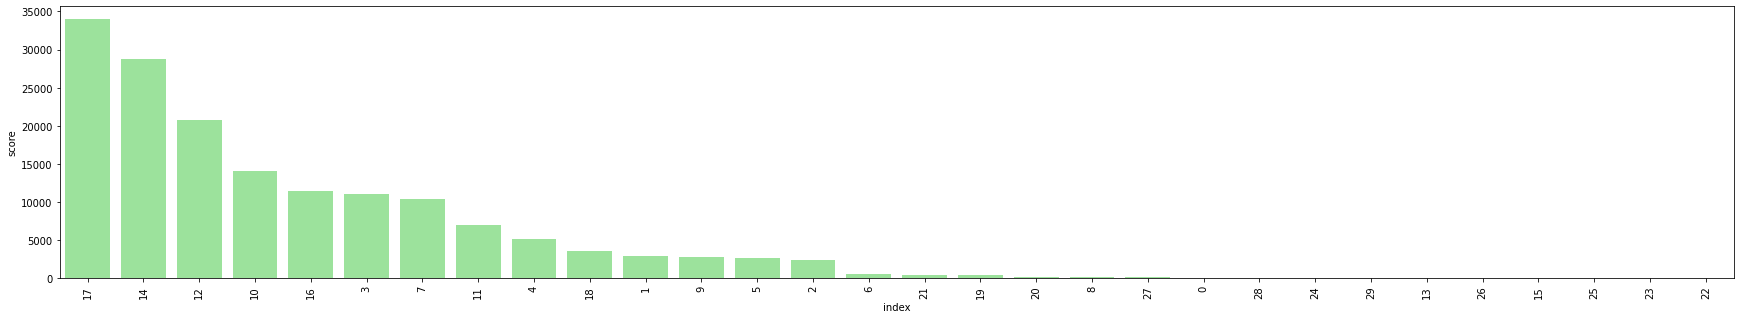

In [42]:
plt.figure(figsize=(30,5))
sns.barplot(scores['index'], scores.score,  order=scores['index'], color='lightgreen')
plt.xticks(rotation=90)
plt.show()

In [43]:
#Aqui fica definida a quantidade de features que seguem na análise
scores_select = scores[scores['index'].isin(np.where(fs.pvalues_>0)[0])]
score_qttd = scores_select.shape[0]

In [44]:
# Definida a quantidade de features, o SelectKBest pode ser rodado novamente
fs = SelectKBest(score_func=f_classif, k=score_qttd)
fs.fit(df_features,df_target)
df_train_fs = pd.DataFrame(fs.transform(df_features))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
df_train_fs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,-0.018307
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.225775
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0.247998
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-0.108300
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,-0.009431


## Árvore de decisão

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_train_fs, df_target, test_size=0.2, random_state=1)

In [47]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

In [48]:
pd.DataFrame(y_pred).value_counts()

0    56888
1       74
dtype: int64

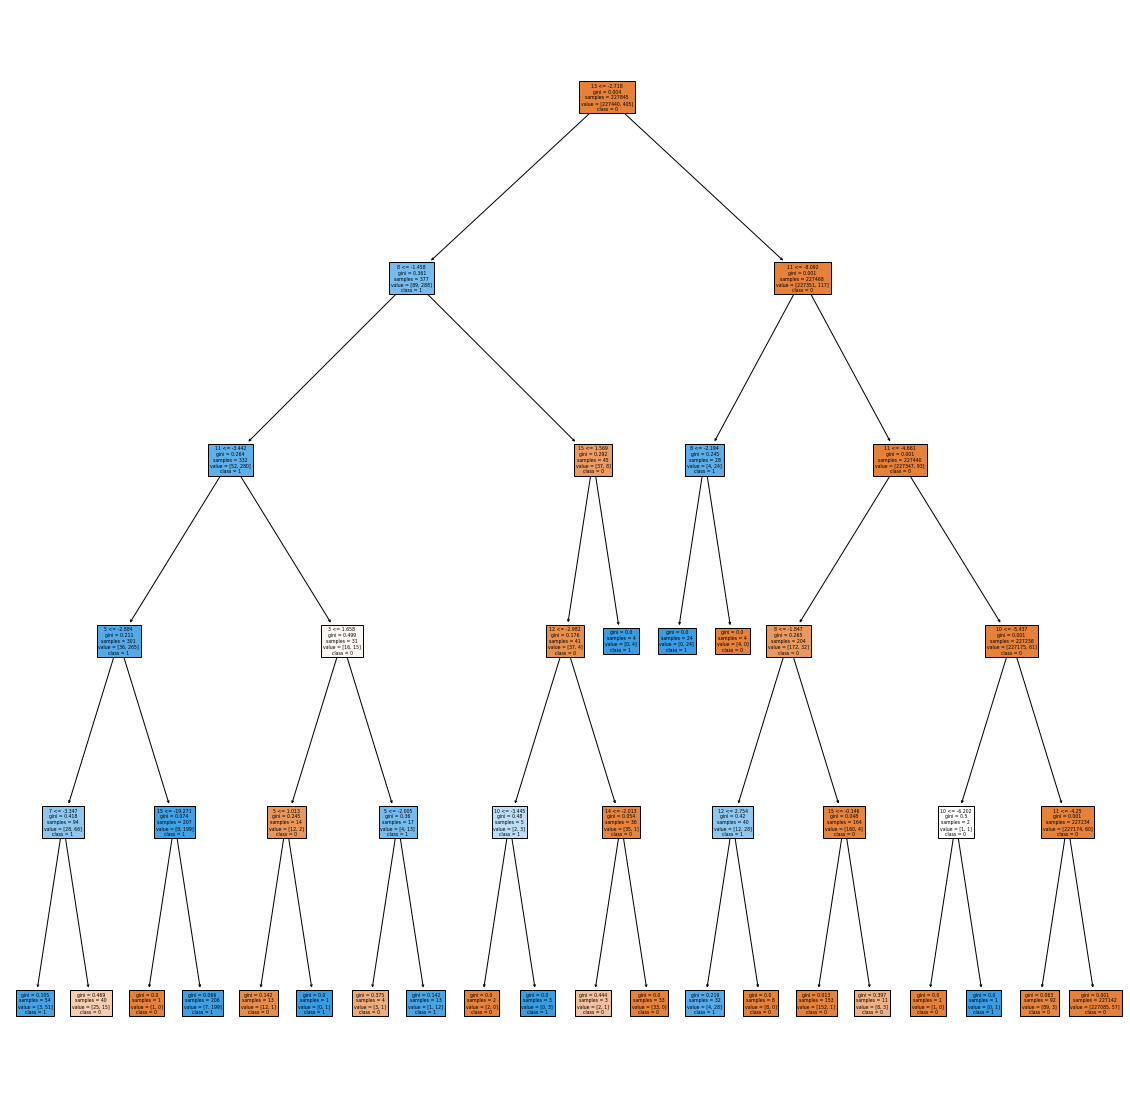

In [49]:
plt.figure(figsize=(20,20))
plot_tree(dt, 
          feature_names=df_train_fs.columns,  
          class_names=["0","1"],
          filled=True)

plt.show()

Test set accuracy: 1.00 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


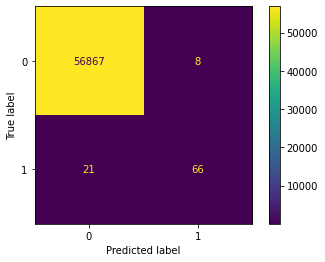

In [50]:
# Agora avalia-se a acurácia dos dados
# Visualização da Matriz de Confusão

y_pred = dt.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f} \n".format(acc))

plot_confusion_matrix(dt, X_test, y_test)  
plt.show()

In [73]:
rfc = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,5,8,16,32,None]
}

cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 5, 8, 16, 32, None],
                         'n_estimators': [5, 10, 50, 100, 250]})

In [74]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

display(cv)

Best parameters are: {'max_depth': 16, 'n_estimators': 250}


0.999 + or -0.0 for the {'max_depth': 2, 'n_estimators': 5}
0.999 + or -0.0 for the {'max_depth': 2, 'n_estimators': 10}
0.999 + or -0.0 for the {'max_depth': 2, 'n_estimators': 50}
0.999 + or -0.0 for the {'max_depth': 2, 'n_estimators': 100}
0.999 + or -0.0 for the {'max_depth': 2, 'n_estimators': 250}
0.999 + or -0.0 for the {'max_depth': 4, 'n_estimators': 5}
0.999 + or -0.0 for the {'max_depth': 4, 'n_estimators': 10}
0.999 + or -0.0 for the {'max_depth': 4, 'n_estimators': 50}
0.999 + or -0.0 for the {'max_depth': 4, 'n_estimators': 100}
0.999 + or -0.0 for the {'max_depth': 4, 'n_estimators': 250}
0.999 + or -0.0 for the {'max_depth': 5, 'n_estimators': 5}
0.999 + or -0.0 for the {'max_depth': 5, 'n_estimators': 10}
0.999 + or -0.0 for the {'max_depth': 5, 'n_estimators': 50}
0.999 + or -0.0 for the {'max_depth': 5, 'n_estimators': 100}
0.999 + or -0.0 for the {'max_depth': 5, 'n_estimators': 250}
0.999 + or -0.0 for 

In [78]:
y_pred_1 = cv.predict(X_test)

Test set accuracy: 1.00 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


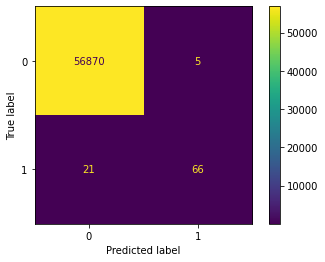

In [82]:
# Agora avalia-se a acurácia dos dados
# Visualização da Matriz de Confusão
acc = accuracy_score(y_test, y_pred_1)
print("Test set accuracy: {:.2f} \n".format(acc))

#plot_confusion_matrix(dt, X_test, y_test)  
plot_confusion_matrix(cv, X_test, y_test)
plt.show()

## Ajustando os dados

A acurácia está muito elevada devido a grande quantidade de acertos de Não Fraudes. Testar um novo caminho diminuindo a quantidade de Não Fraudes para próximo da quantidade de fraudes e refazendo o cenário.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
X_resampled, y_resampled = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train)

In [ ]:
print(y_train.value_counts())
print(y_resampled.value_counts())


Class
0        227440
1           405
dtype: int64
Class
1        405
0        405
dtype: int64


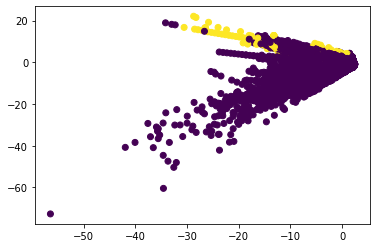

In [ ]:
plt.scatter(X_train[0], X_train[1], c = y_train['Class'])

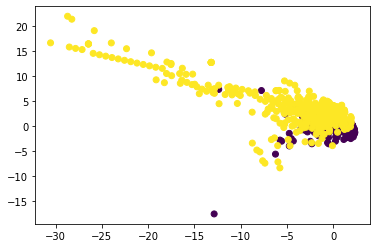

In [ ]:
plt.scatter(X_resampled[0], X_resampled[1], c = y_resampled['Class'])

In [ ]:
dt_new = DecisionTreeClassifier(max_depth=5, random_state=42)

dt_new.fit(X_resampled, y_resampled)

y_pred_new = dt_new.predict(X_test)

In [ ]:
pd.DataFrame(y_pred_new).value_counts()

0    53168
1     3794
dtype: int64

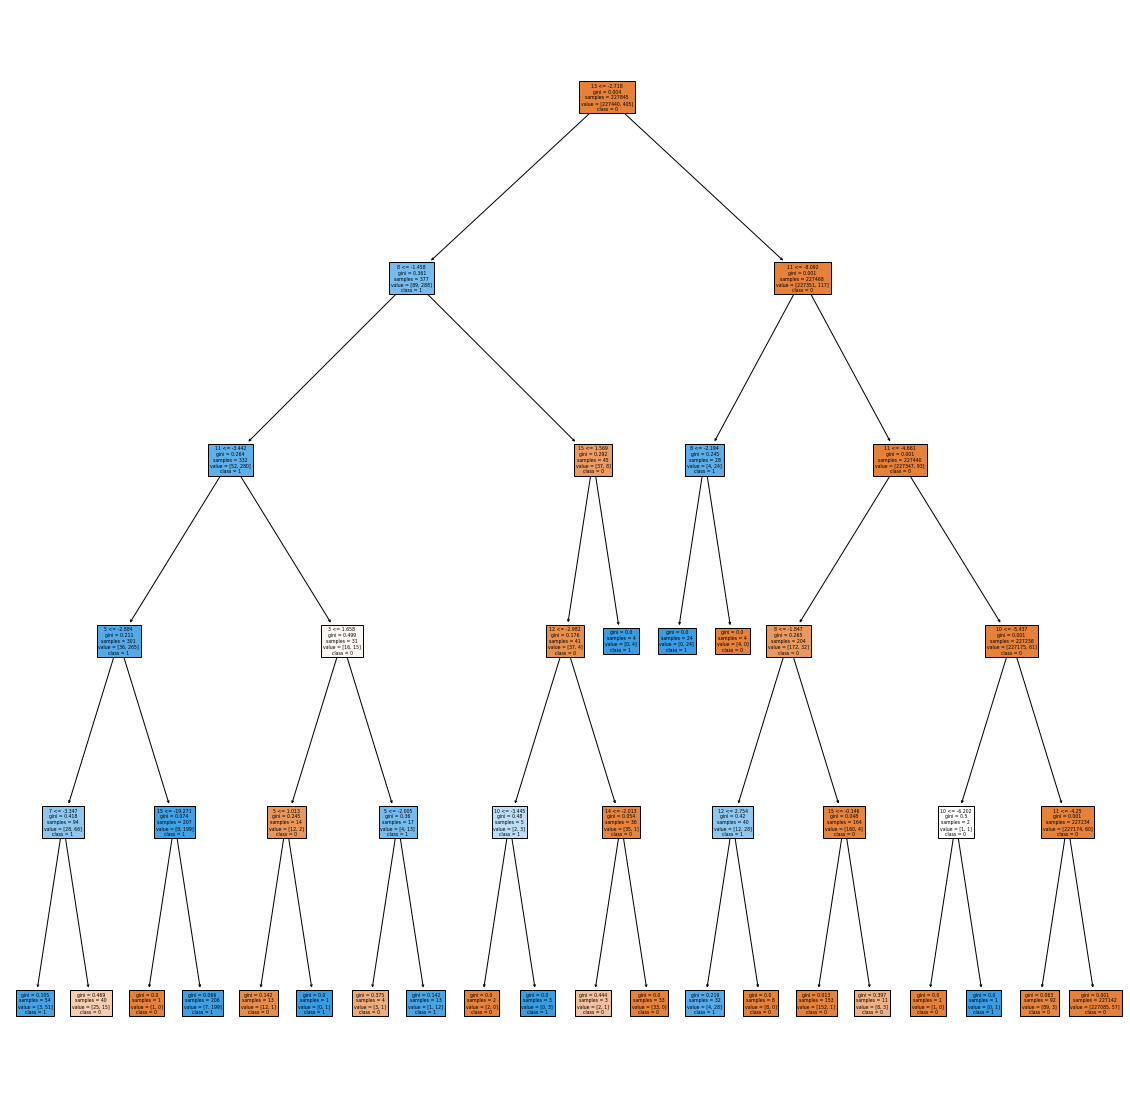

In [ ]:
plt.figure(figsize=(20,20))
plot_tree(dt, 
          feature_names=df_train_fs.columns,  
          class_names=["0","1"],
          filled=True)

plt.show()

Test set accuracy: 1.00 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


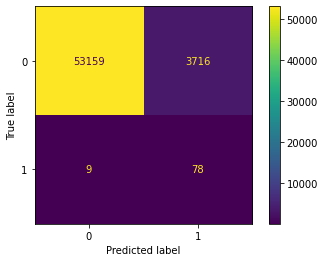

In [ ]:
# Agora avalia-se a acurácia dos dados
# Visualização da Matriz de Confusão

y_pred_new = dt.predict(X_test)

acc = accuracy_score(y_test, y_pred_new)
print("Test set accuracy: {:.2f} \n".format(acc))

plot_confusion_matrix(dt_new, X_test, y_test)  
plt.show()

## DBSCAN

In [ ]:
# Aplicando a metrica para calcular a quantidade de Centróides
Centr = round(np.log(df_z.shape[0]))
print(Centr)

13


In [ ]:
# Aplicando a metodologia para calcular o Epsilon
neigh = NearestNeighbors(n_neighbors=Centr)
nbrs = neigh.fit(df_z.head(50000))
distances, indices = nbrs.kneighbors(df_z.head(50000))

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

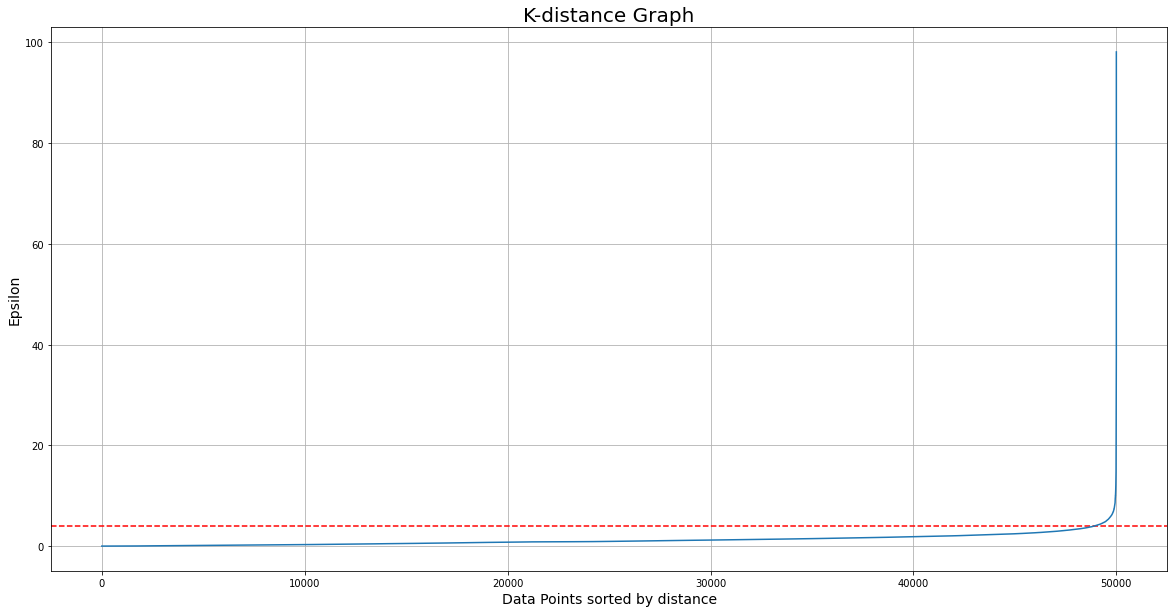

In [ ]:
# Plotting K-distance Graph
plt.figure(figsize=(20,10))
plt.axhline(y=4, c="red", linestyle='--') #definido
plt.plot(distances)
plt.grid()
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [ ]:
model = DBSCAN(eps = 4, min_samples = Centr).fit(df_z.head(50000))

In [ ]:
new_df = df_z.head(50000)
new_df['result'] = model.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
new_df[['result','Class']].value_counts()

result  Class     
 0      -0.041599     44758
 1      -0.041599      3033
-1      -0.041599      2048
         24.039052      148
 2      -0.041599        13
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


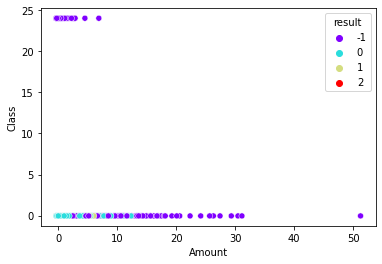

In [ ]:
sns.scatterplot(new_df["Amount"], new_df["Class"], hue = new_df.result, palette="rainbow")
plt.show()

## Conclusão

Baseado nos resultados analisados, temos que o modelo com RandomForestClassifier obteve o melhor desempenho.